### Todo:
- Normalize test set with same parameters as train set (use library)
- Visualize graphs of predictions
- Better success metric -> Predicting all 0's gets you 99.2% accuracy, we need a different metric to measure

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils.np_utils import to_categorical
from keras import metrics
from keras.callbacks import ModelCheckpoint

from pathlib import Path

from sklearn import cross_validation
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import math
import time

%matplotlib inline
np.random.seed(1)

# stdsc = StandardScaler()
# mms = MinMaxScaler()

LOAD_MODEL = False # continue training previous weights or start fresh


Using TensorFlow backend.
/Users/Gabriel/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/Gabriel/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Visualize Examples

In [2]:
train_dataset_path = "./datasets/exoTrain.csv"
df = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1")

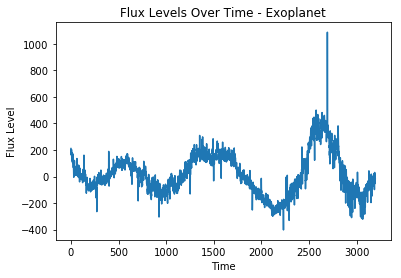

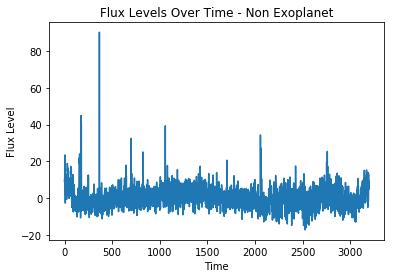

In [3]:
fluxes = df.iloc[5,1:].values
plt.plot(fluxes)
plt.ylabel('Flux Level')
plt.xlabel('Time')
plt.title("Flux Levels Over Time - Exoplanet")
plt.show()

fluxes_non_exo = df.iloc[50,1:].values
plt.plot(fluxes_non_exo)
plt.ylabel('Flux Level')
plt.xlabel('Time')
plt.title("Flux Levels Over Time - Non Exoplanet")
plt.show()

## Train and Dev Sets

In [4]:
train_dataset_path = "./datasets/exoTrain.csv"
dev_dataset_path = "./datasets/exoTest.csv"

df_train = pd.read_csv(train_dataset_path, encoding = "ISO-8859-1")
df_dev = pd.read_csv(dev_dataset_path, encoding = "ISO-8859-1")

In [5]:
print(df_train.shape)
print(df_dev.shape)

(5087, 3198)
(570, 3198)


In [6]:
def X_Y_from_df(df):
    df = shuffle(df)
    df_X = df.drop(['LABEL'], axis=1)
#     df_X = (df_X - df_X.mean()) / df_X.std()
    X = np.array(df_X)
    Y_raw = np.array(df['LABEL']).reshape((len(df['LABEL']),1))
    Y = Y_raw == 2
    return X, Y

In [9]:
def augment_data(df):
    print("Shape before augmentation:",df.shape)
    # Get exoplanet positive examples
    label_2_indexes = df['LABEL'] == 2
    df_2 = df[label_2_indexes]
    
    # Separate labels from feature
    df_2_labels = df_2['LABEL']
    df_2_X = df_2.drop(['LABEL'], axis=1)
    
    # Reverse features
    X_columns = df_2_X.columns.tolist()
    X_columns_reversed = X_columns[::-1]
    df_2_X = df_2_X[X_columns_reversed]
    
    # Concat labels with features
    df_2 = pd.concat([df_2_labels,df_2_X], axis=1)
    
    # Add new augmented examples to original dataframe
    df = pd.concat([df,df_2])
    
    print("Shape after augmentation:",df.shape)
    return df

In [8]:
# Augment data
df_train = augment_data(df_train)

# Print number of positive exoplanet examples after augmenting data
df_train_i = df_train['LABEL'] == 2
print(np.sum(df_train_i))


(5087, 3198)
(5124, 3198)
74


In [10]:
# Load X and Y
X_train, Y_train = X_Y_from_df(df_train)
X_dev, Y_dev = X_Y_from_df(df_dev)

# Standardize X data
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_dev = std_scaler.transform(X_dev)

In [11]:
# Print data set stats
(num_examples, n_x) = X_train.shape # (n_x: input size, m : number of examples in the train set)
n_y = Y_train.shape[1] # n_y : output size

print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)
print("X_dev.shape: ", X_dev.shape)
print("Y_dev.shape: ", Y_dev.shape)
print("n_x: ", n_x)
print("num_examples: ", num_examples)
print("n_y: ", n_y)

X_train.shape:  (5124, 3197)
Y_train.shape:  (5124, 1)
X_dev.shape:  (570, 3197)
Y_dev.shape:  (570, 1)
n_x:  3197
num_examples:  5124
n_y:  1


## Build Model

In [32]:
# Model config
learning_rate = 0.001
n_l1 = 32
n_l2 = 64
n_l3 = 256
n_l4 = 256
n_l5 = 64
n_l6 = 32
# Build model
model = Sequential()

model.add(Dense(units=n_l1, input_dim=n_x))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(units=n_l2, input_dim=n_l1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(units=n_l3, input_dim=n_l1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(units=n_l4, input_dim=n_l1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(units=n_l5, input_dim=n_l1))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(units=n_l6, input_dim=n_l1))
model.add(Activation('relu'))
model.add(Dropout(0.2))


model.add(Dense(units=n_y))
model.add(Activation('sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

In [25]:
# Load weights
# filepath="weights-{epoch:02d}-{val_acc:.2f}.hdf5"
# load_path="keras_ckpts/weights-best.hdf5"
load_path="keras_ckpts/weights-acc-0.8629353848325511-0.858685296919657.hdf5"
my_file = Path(load_path)
if LOAD_MODEL and my_file.is_file():
    model.load_weights(load_path)
    print("loaded saved weights")

In [33]:
# Train
# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

history = model.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
5124/5124 [==============================] - 2s - loss: 0.1330 - acc: 0.9846       

In [30]:
# Accuracy
train_outputs = model.predict(X_train, batch_size=32)
dev_outputs = model.predict(X_dev, batch_size=32)
train_outputs = np.rint(train_outputs)
dev_outputs = np.rint(dev_outputs)
accuracy_train = accuracy_score(Y_train, train_outputs)
accuracy_dev = accuracy_score(Y_dev, dev_outputs)
precision_train = precision_score(Y_train, train_outputs)
precision_dev = precision_score(Y_dev, dev_outputs)
recall_train = recall_score(Y_train, train_outputs)
recall_dev = recall_score(Y_dev, dev_outputs)
confusion_matrix_train = confusion_matrix(Y_train, train_outputs)
confusion_matrix_dev = confusion_matrix(Y_dev, dev_outputs)

print("train set error", 1.0 - accuracy_train)
print("dev set error", 1.0 - accuracy_dev)

print("------------")

print("precision_train", precision_train)
print("precision_dev", precision_dev)

print("------------")

print("recall_train", recall_train)
print("recall_dev", recall_dev)

print("------------")

print("confusion_matrix_train")
print(confusion_matrix_train)
print("confusion_matrix_dev")
print(confusion_matrix_dev)


print("------------")

print("Train Set Positive Predictions", np.count_nonzero(train_outputs))
print("Dev Set Positive Predictions", np.count_nonzero(dev_outputs))

#  Predicting 0's will give you error:
print("------------")
print("All 0's error train set", 37/5087)
print("All 0's error dev set", 5/570)

train set error 0.0119047619048
dev set error 0.0105263157895
------------
precision_train 0.740740740741
precision_dev 0.0
------------
recall_train 0.27027027027
recall_dev 0.0
------------
confusion_matrix_train
[[5043    7]
 [  54   20]]
confusion_matrix_dev
[[564   1]
 [  5   0]]
------------
Train Set Positive Predictions 27
Dev Set Positive Predictions 1
------------
All 0's error train set 0.007273442107332416
All 0's error dev set 0.008771929824561403


In [31]:
# Save model
save_weights_path = "checkpoints/weights-recall-{}-{}.hdf5".format(recall_train, recall_dev) # load_path
model.save_weights(save_weights_path)

save_path = "models/model-recall-{}-{}.hdf5".format(recall_train, recall_dev) # load_path
model.save(save_path)


dict_keys(['loss', 'acc'])


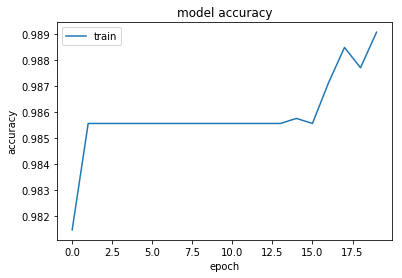

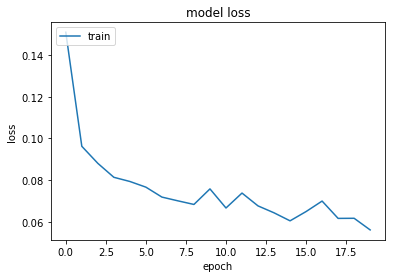

In [29]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()